## CARDIOVASCULAR DISEASE KNN CLASSIFICATION MODEL 

**INTRODUCTION**

According to the World Health Organization, cardiovascular disease is the leading global cause of death. In fact, over 17.9 million patients die from the disease each year (Centers for Disease Control and Prevention, 2022). Cardiovascular disease is characterized by high blood pressure, cholesterol and chest pain leading to heart failure, arrhythmia and heart attack symptoms (World Health Organization, 2023).

Due to the growing prevalence of machine learning algorithms in the health care sector, our goal is to create and train a model using the KNN classification algorithm that will predict whether individuals are likely to have cardiovascular disease based on various clinical attributes. 

**Research question**: Which individuals are likely to have cardiovascular disease according to various clinical attributes?

The "hungarian heart disease" dataset obtained from the machine learning repository contains 294 observations representing the patients of the study. It has 14 columns with various clinical attributes associated with cardiovascular disease as well as the patient's diagnosis (UCI Machine Learning Respository, 2023).

**PRELIMINARY DATA ANALYSIS**

In [21]:
#We begin by loading the data set into R and adding column names. 
library(tidyverse)
library(tidymodels)
set.seed(123)

heart_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data", col_names = FALSE)

heart_data_renamed <- rename(heart_data, 
                        age = X1, 
                        sex = X2, 
                        chest_pain_type= X3, 
                        resting_blood_pressure = X4, 
                        serum_cholestoral = X5, 
                        fasting_blood_sugar = X6, 
                        resting_electrocardiographic_results = X7, 
                        max_heart_rate = X8, 
                        exercise_induced_angina = X9, 
                        oldpeak = X10, 
                        slope = X11, 
                        number_vessels = X12, 
                        thal = X13, 
                        diagnosis = X14)            

heart_data_renamed <- heart_data_renamed |>
    mutate(across(c(diagnosis, sex, chest_pain_type, fasting_blood_sugar, resting_electrocardiographic_results,exercise_induced_angina), as.factor))|>
    mutate(across(c(resting_blood_pressure), as.numeric))

head(heart_data_renamed)


Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


age,sex,chest_pain_type,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_electrocardiographic_results,max_heart_rate,exercise_induced_angina,oldpeak,slope,number_vessels,thal,diagnosis
<dbl>,<fct>,<fct>,<dbl>,<chr>,<fct>,<fct>,<chr>,<fct>,<dbl>,<chr>,<chr>,<chr>,<fct>
28,1,2,130,132,0,2,185,0,0,?,?,?,0
29,1,2,120,243,0,0,160,0,0,?,?,?,0
29,1,2,140,?,0,0,170,0,0,?,?,?,0
30,0,1,170,237,0,1,170,0,0,?,?,6,0
31,0,2,100,219,0,1,150,0,0,?,?,?,0
32,0,2,105,198,0,0,165,0,0,?,?,?,0


In [22]:
#We can create a new dataframe with the age, resting blood pressure, blood cholestoral, maximum heart rate, and diagnosis variables and filter out the observations with missing values. We choose to examine these variables because they are numeric and have minimal missing values.  

tidy_heart_data <- heart_data_renamed  |>
    select(age, resting_blood_pressure, serum_cholestoral, max_heart_rate, diagnosis) |>
    filter(age != "?", resting_blood_pressure != "?", serum_cholestoral != "?", max_heart_rate != "?", diagnosis != "?")
head(tidy_heart_data)

age,resting_blood_pressure,serum_cholestoral,max_heart_rate,diagnosis
<dbl>,<dbl>,<chr>,<chr>,<fct>
28,130,132,185,0
29,120,243,160,0
30,170,237,170,0
31,100,219,150,0
32,105,198,165,0
32,110,225,184,0


In [23]:
#We can divide our dataset into a training and testing set using set.seed for a random yet reproducible split. 

split_heart_data <- initial_split(tidy_heart_data, prop = 0.75, strata = diagnosis)
training_heart_data <- training(split_heart_data)
testing_heart_data <- testing(split_heart_data)
glimpse(training_heart_data) 
glimpse(testing_heart_data)

Rows: 201
Columns: 5
$ age                    <dbl> 31, 32, 32, 32, 33, 34, 34, 35, 35, 35, 36, 36,…
$ resting_blood_pressure <dbl> 100, 105, 110, 125, 120, 130, 98, 120, 140, 120…
$ serum_cholestoral      <chr> "219", "198", "225", "254", "298", "161", "220"…
$ max_heart_rate         <chr> "150", "165", "184", "155", "185", "190", "150"…
$ diagnosis              <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
Rows: 69
Columns: 5
$ age                    <dbl> 28, 29, 30, 34, 35, 36, 37, 38, 38, 39, 41, 41,…
$ resting_blood_pressure <dbl> 130, 120, 170, 150, 150, 130, 120, 140, 145, 19…
$ serum_cholestoral      <chr> "132", "243", "237", "214", "264", "209", "260"…
$ max_heart_rate         <chr> "185", "160", "170", "168", "168", "178", "130"…
$ diagnosis              <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…


In [24]:
#We can now use the training data to create a summary table that shows the number and percentage of observations that do and do not have a heart disease diagnosis. 

summary_heart_data <- training_heart_data|>
    group_by(diagnosis)|>
    summarize(Count=n())|>
    mutate(Percent = Count/201)
summary_heart_data

diagnosis,Count,Percent
<fct>,<int>,<dbl>
0,126,0.6268657
1,75,0.3731343


In [25]:
#We can create a summary table of means for the potential predictor variables. 

summary_heart_data_2 <- training_heart_data |>
    summarize(mean_age = mean(age, na.rm = TRUE), 
                mean_blood_pressure = mean(as.numeric(resting_blood_pressure), na.rm = TRUE),
                mean_cholestoral = mean(as.numeric(serum_cholestoral), na.rm = TRUE),
                mean_max_heart_rate = mean(as.numeric(max_heart_rate), na.rm = TRUE))
summary_heart_data_2

mean_age,mean_blood_pressure,mean_cholestoral,mean_max_heart_rate
<dbl>,<dbl>,<dbl>,<dbl>
48.22388,132.2786,253.3682,140.01


The average patient was middle-aged and had elevated blood pressures (healthy range < 120mm/Hg) and blood cholesterol (healthy levels < 200mg/dL) (UptoDate, 2023). The average maximum heart rates appear to be relatively normal (WebMD, 2021).

We now plot graphs using the training data to compare variables to each other while colouring the points by diagnosis and making them transparent due to overlapping points. 

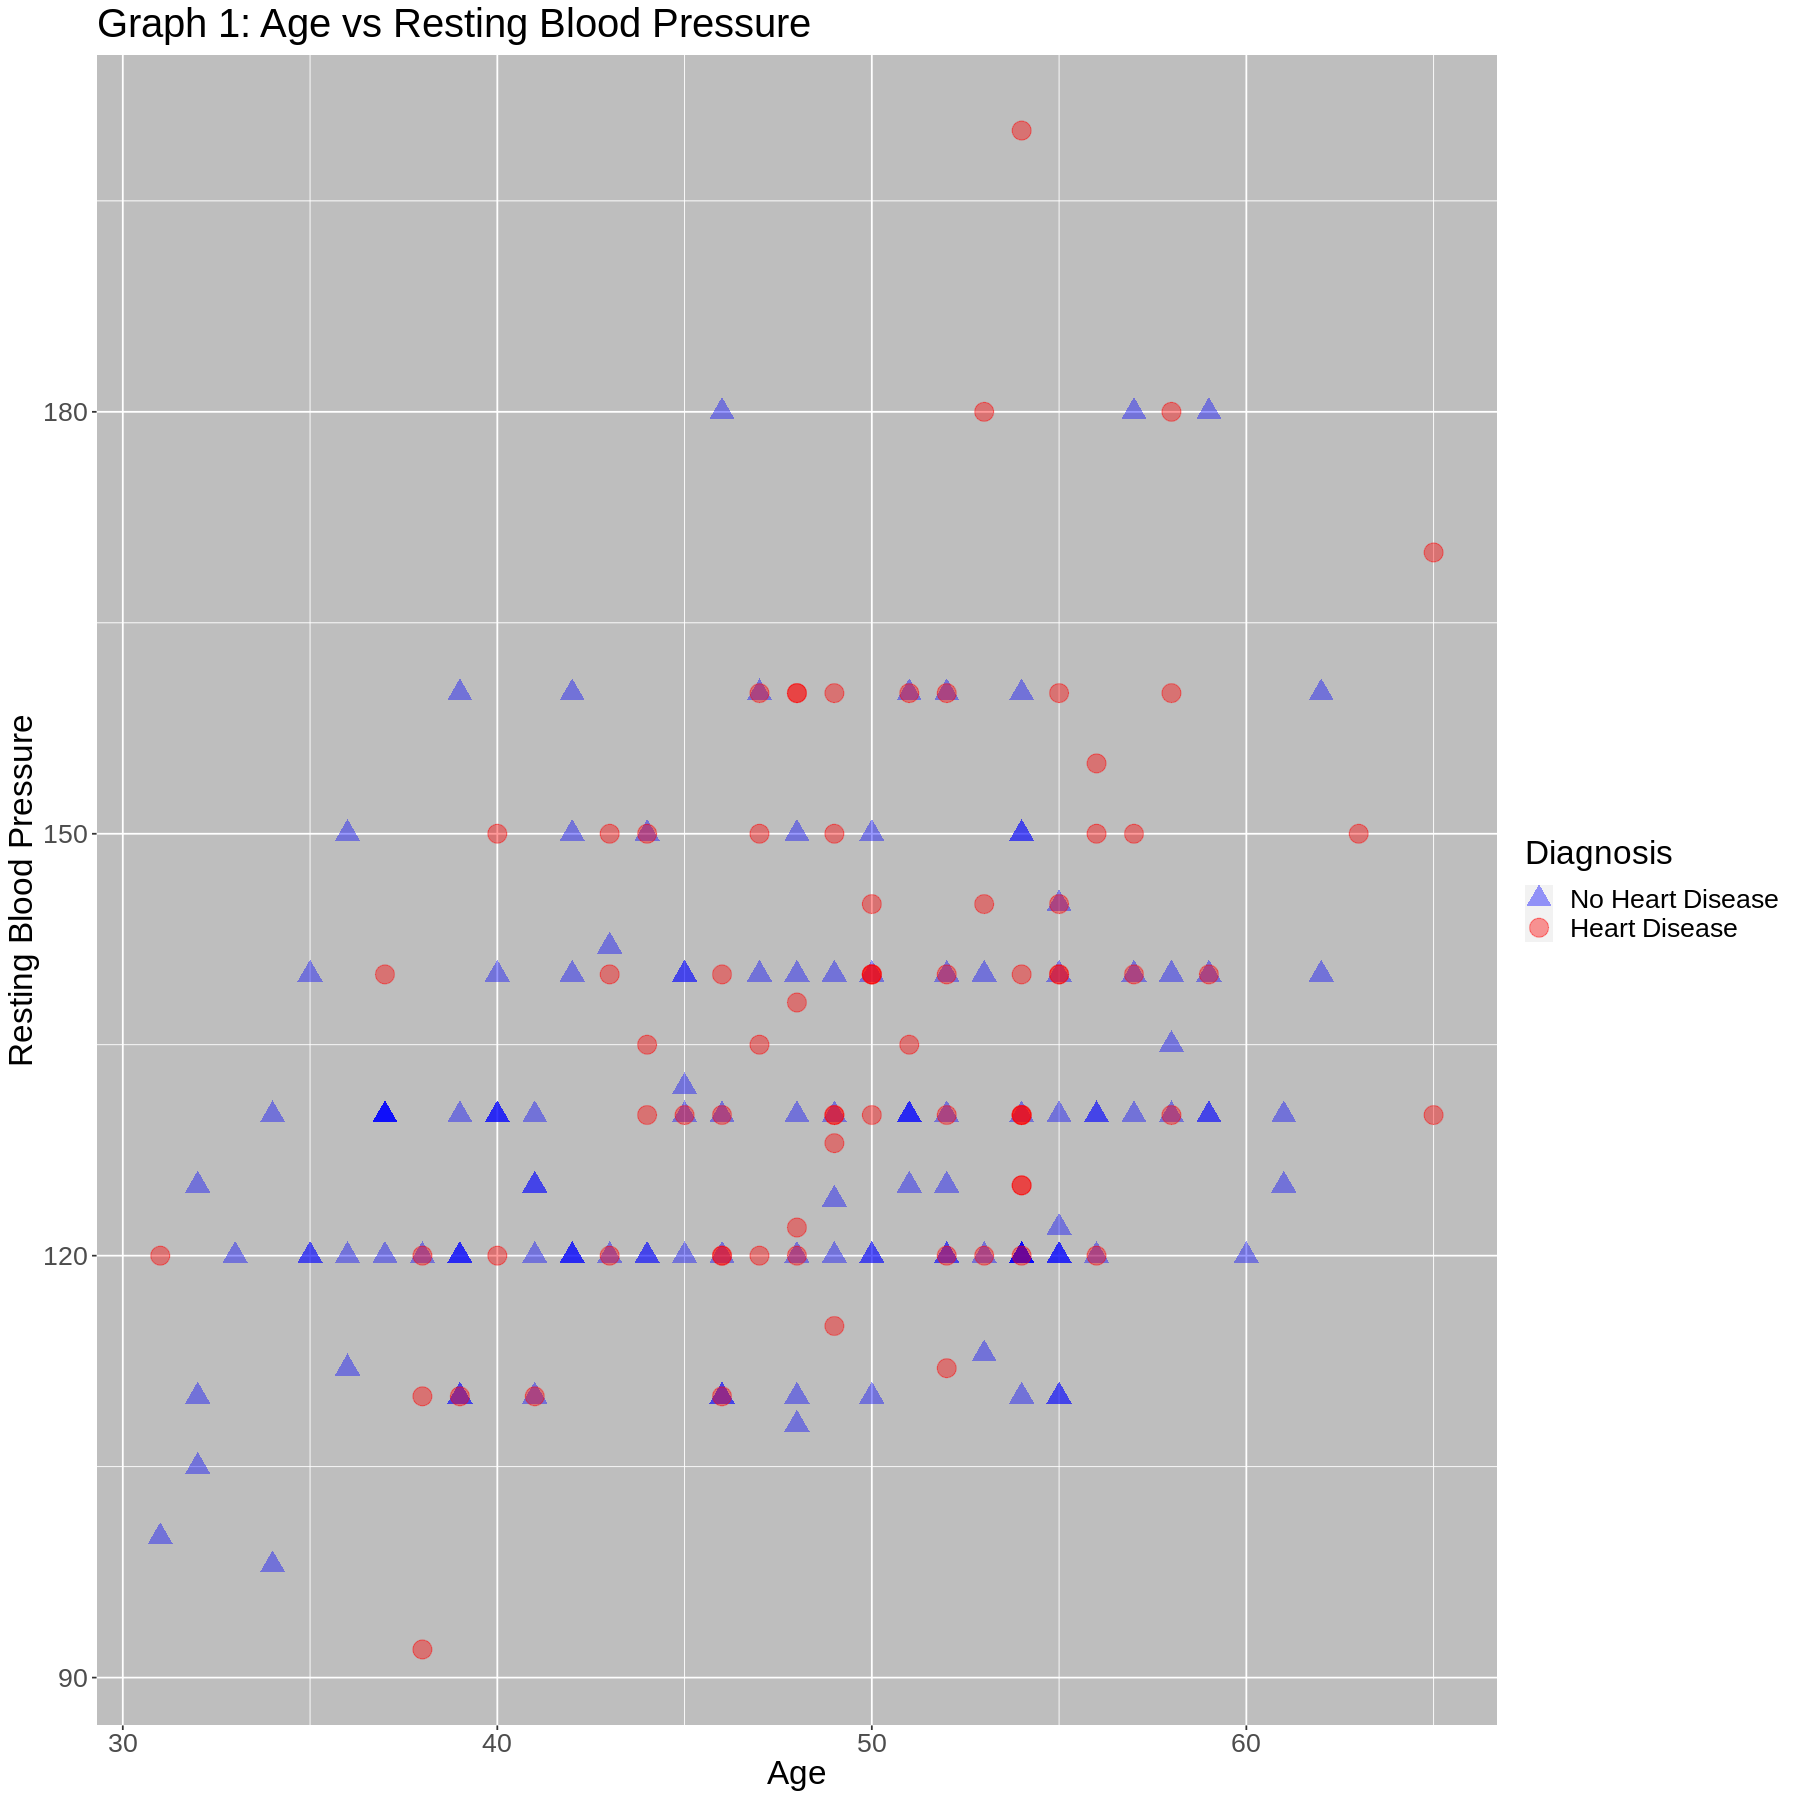

In [26]:
options(repr.plot.width = 15, repr.plot.height = 15)
age_vs_blood_pressure_plot <- training_heart_data |>
    ggplot(aes(x = age, y = as.numeric(resting_blood_pressure), color = as.factor(diagnosis), shape = as.factor(diagnosis))) +
    geom_point(alpha = 0.4, size = 5) +
    labs(x = "Age", y = "Resting Blood Pressure", color = "Diagnosis", shape = "Diagnosis") +
    theme(text = element_text(size = 20), panel.background = element_rect(fill = "grey")) +
    scale_color_manual(labels = c("No Heart Disease", "Heart Disease"), values = c("blue", "red")) +
    scale_shape_manual(labels = c("No Heart Disease", "Heart Disease"), values = c("triangle", "circle")) +
    ggtitle("Graph 1: Age vs Resting Blood Pressure")
age_vs_blood_pressure_plot

We do not see a relationship between age and resting blood pressure because the diagnosed and undiagnosed data points are evenly distributed. 

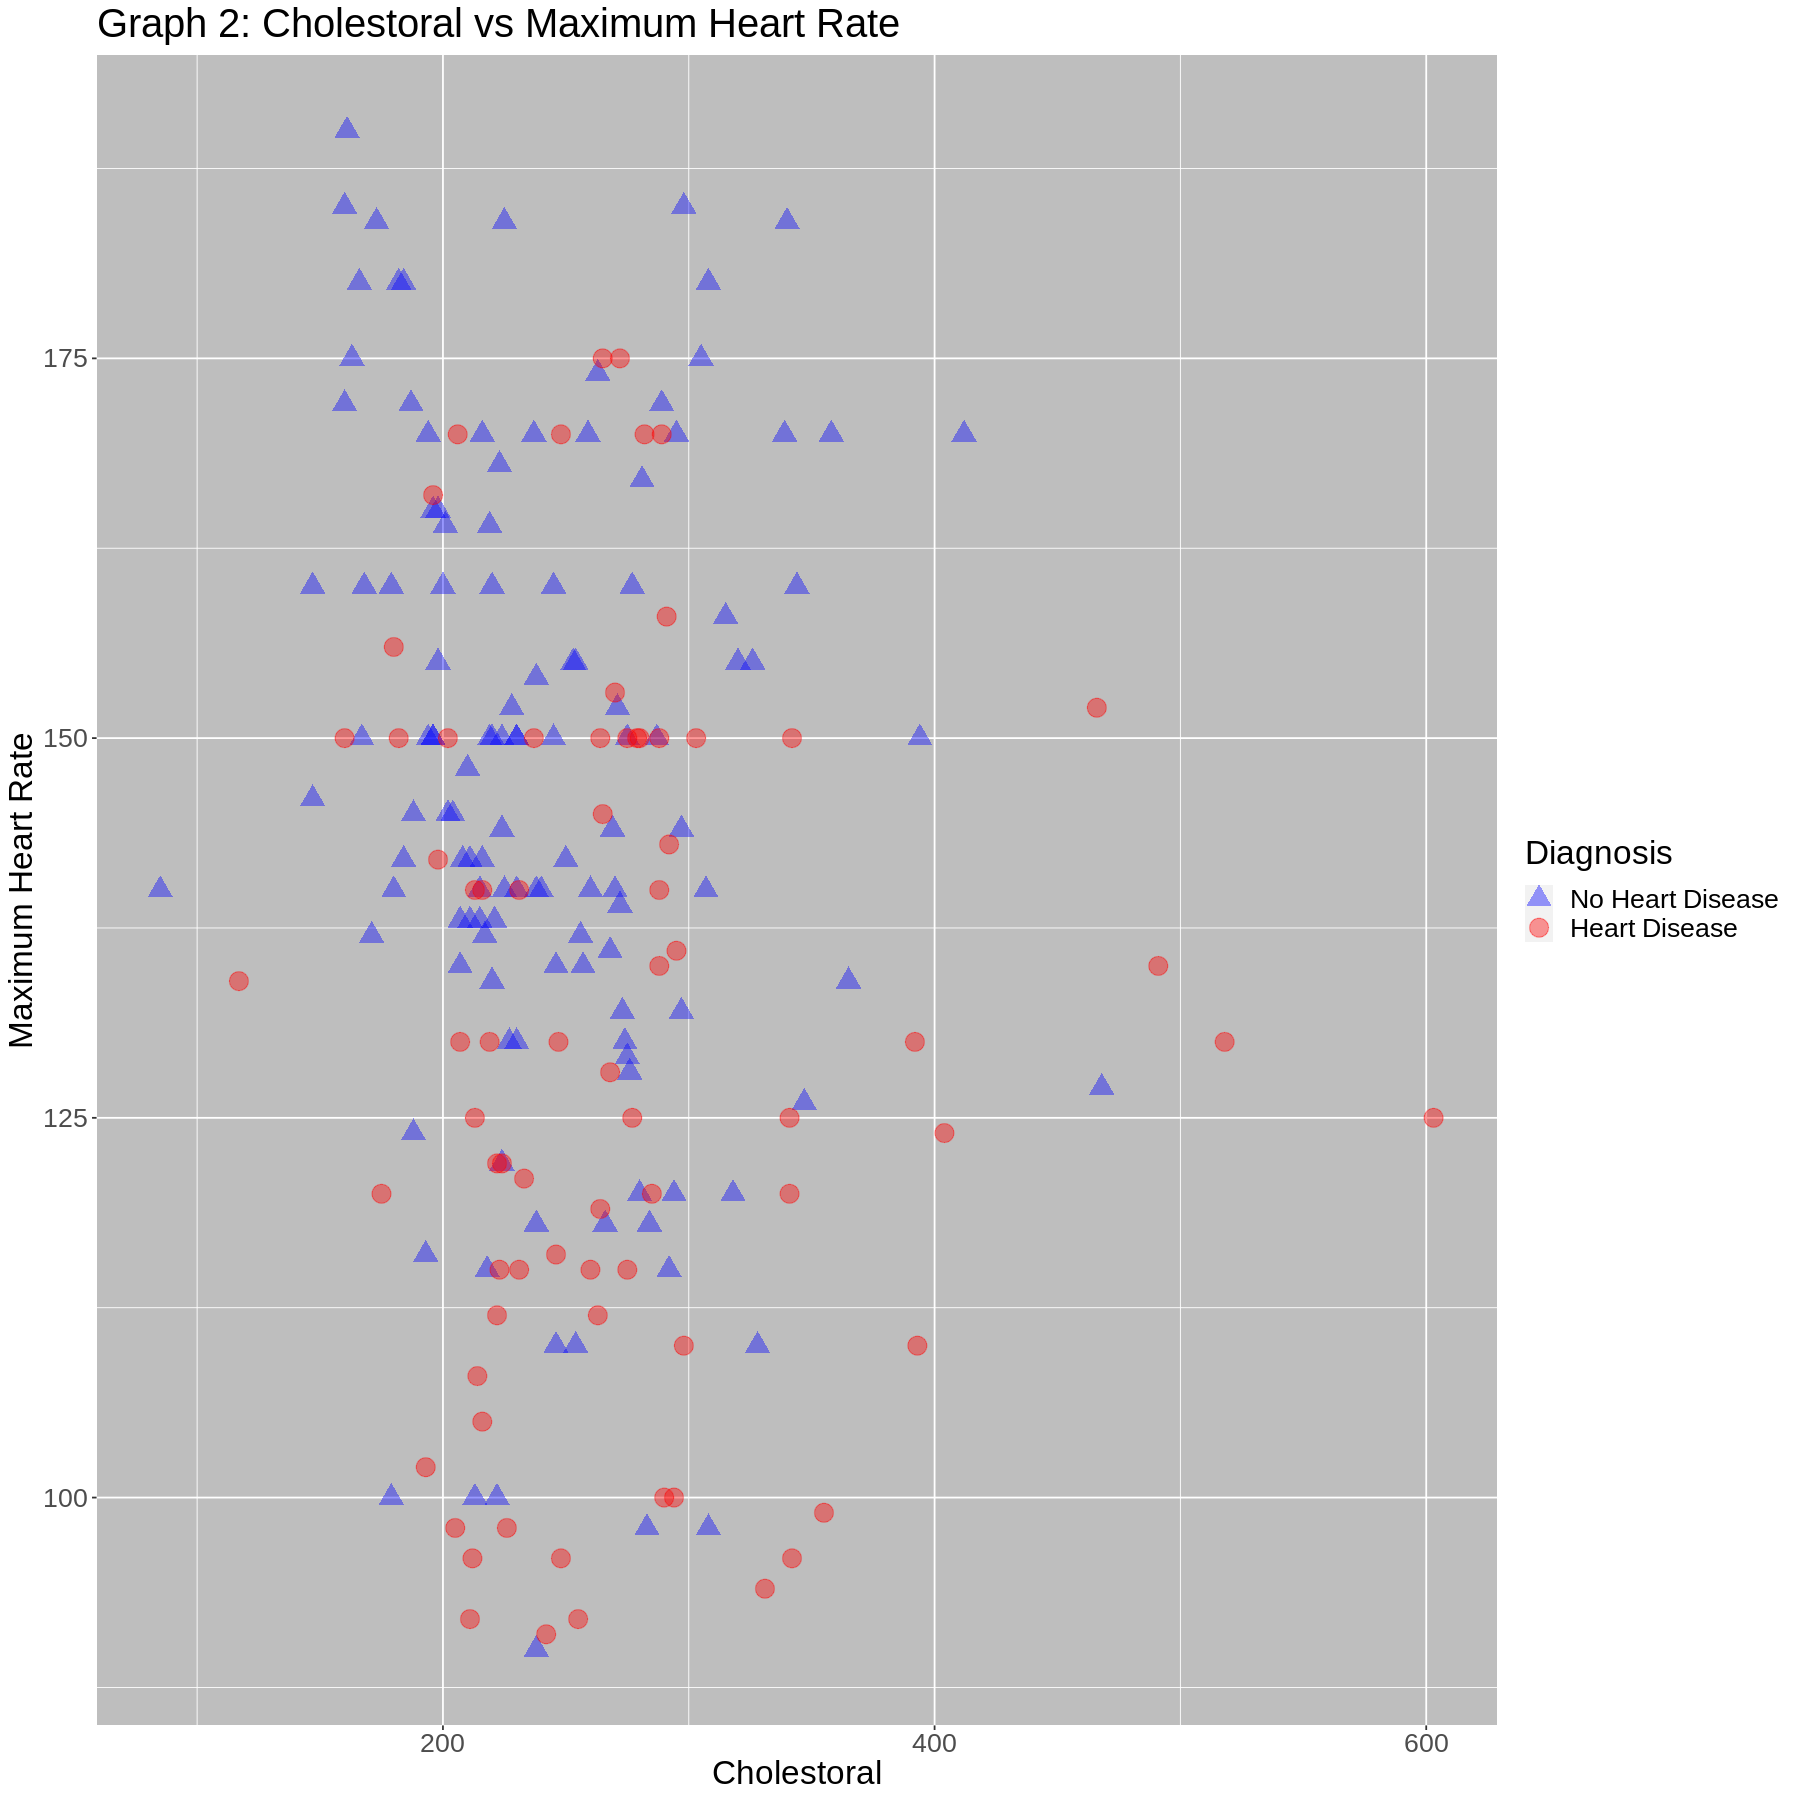

In [27]:
options(repr.plot.width = 15, repr.plot.height = 15)
age_vs_max_heart_rate_plot <- training_heart_data |>
    ggplot(aes(x = as.numeric(serum_cholestoral), y = as.numeric(max_heart_rate), color = as.factor(diagnosis), shape = as.factor(diagnosis))) +
    geom_point(alpha = 0.4, size = 5) +
    labs(x = "Cholestoral", y = "Maximum Heart Rate", color = "Diagnosis", shape = "Diagnosis") +
    theme(text = element_text(size = 20), panel.background = element_rect(fill = "grey")) +
    scale_color_manual(labels = c("No Heart Disease", "Heart Disease"), values = c("blue", "red")) +
    scale_shape_manual(labels = c("No Heart Disease", "Heart Disease"), values = c("triangle", "circle")) +
    ggtitle("Graph 2: Cholestoral vs Maximum Heart Rate")
age_vs_max_heart_rate_plot 


Patients with higher maximum heart rate were diagnosed less often. Patient's with higher cholesterol were diagnosed more often. There doesn't appear to be a relationship between maximum heart rate and cholestoral.  

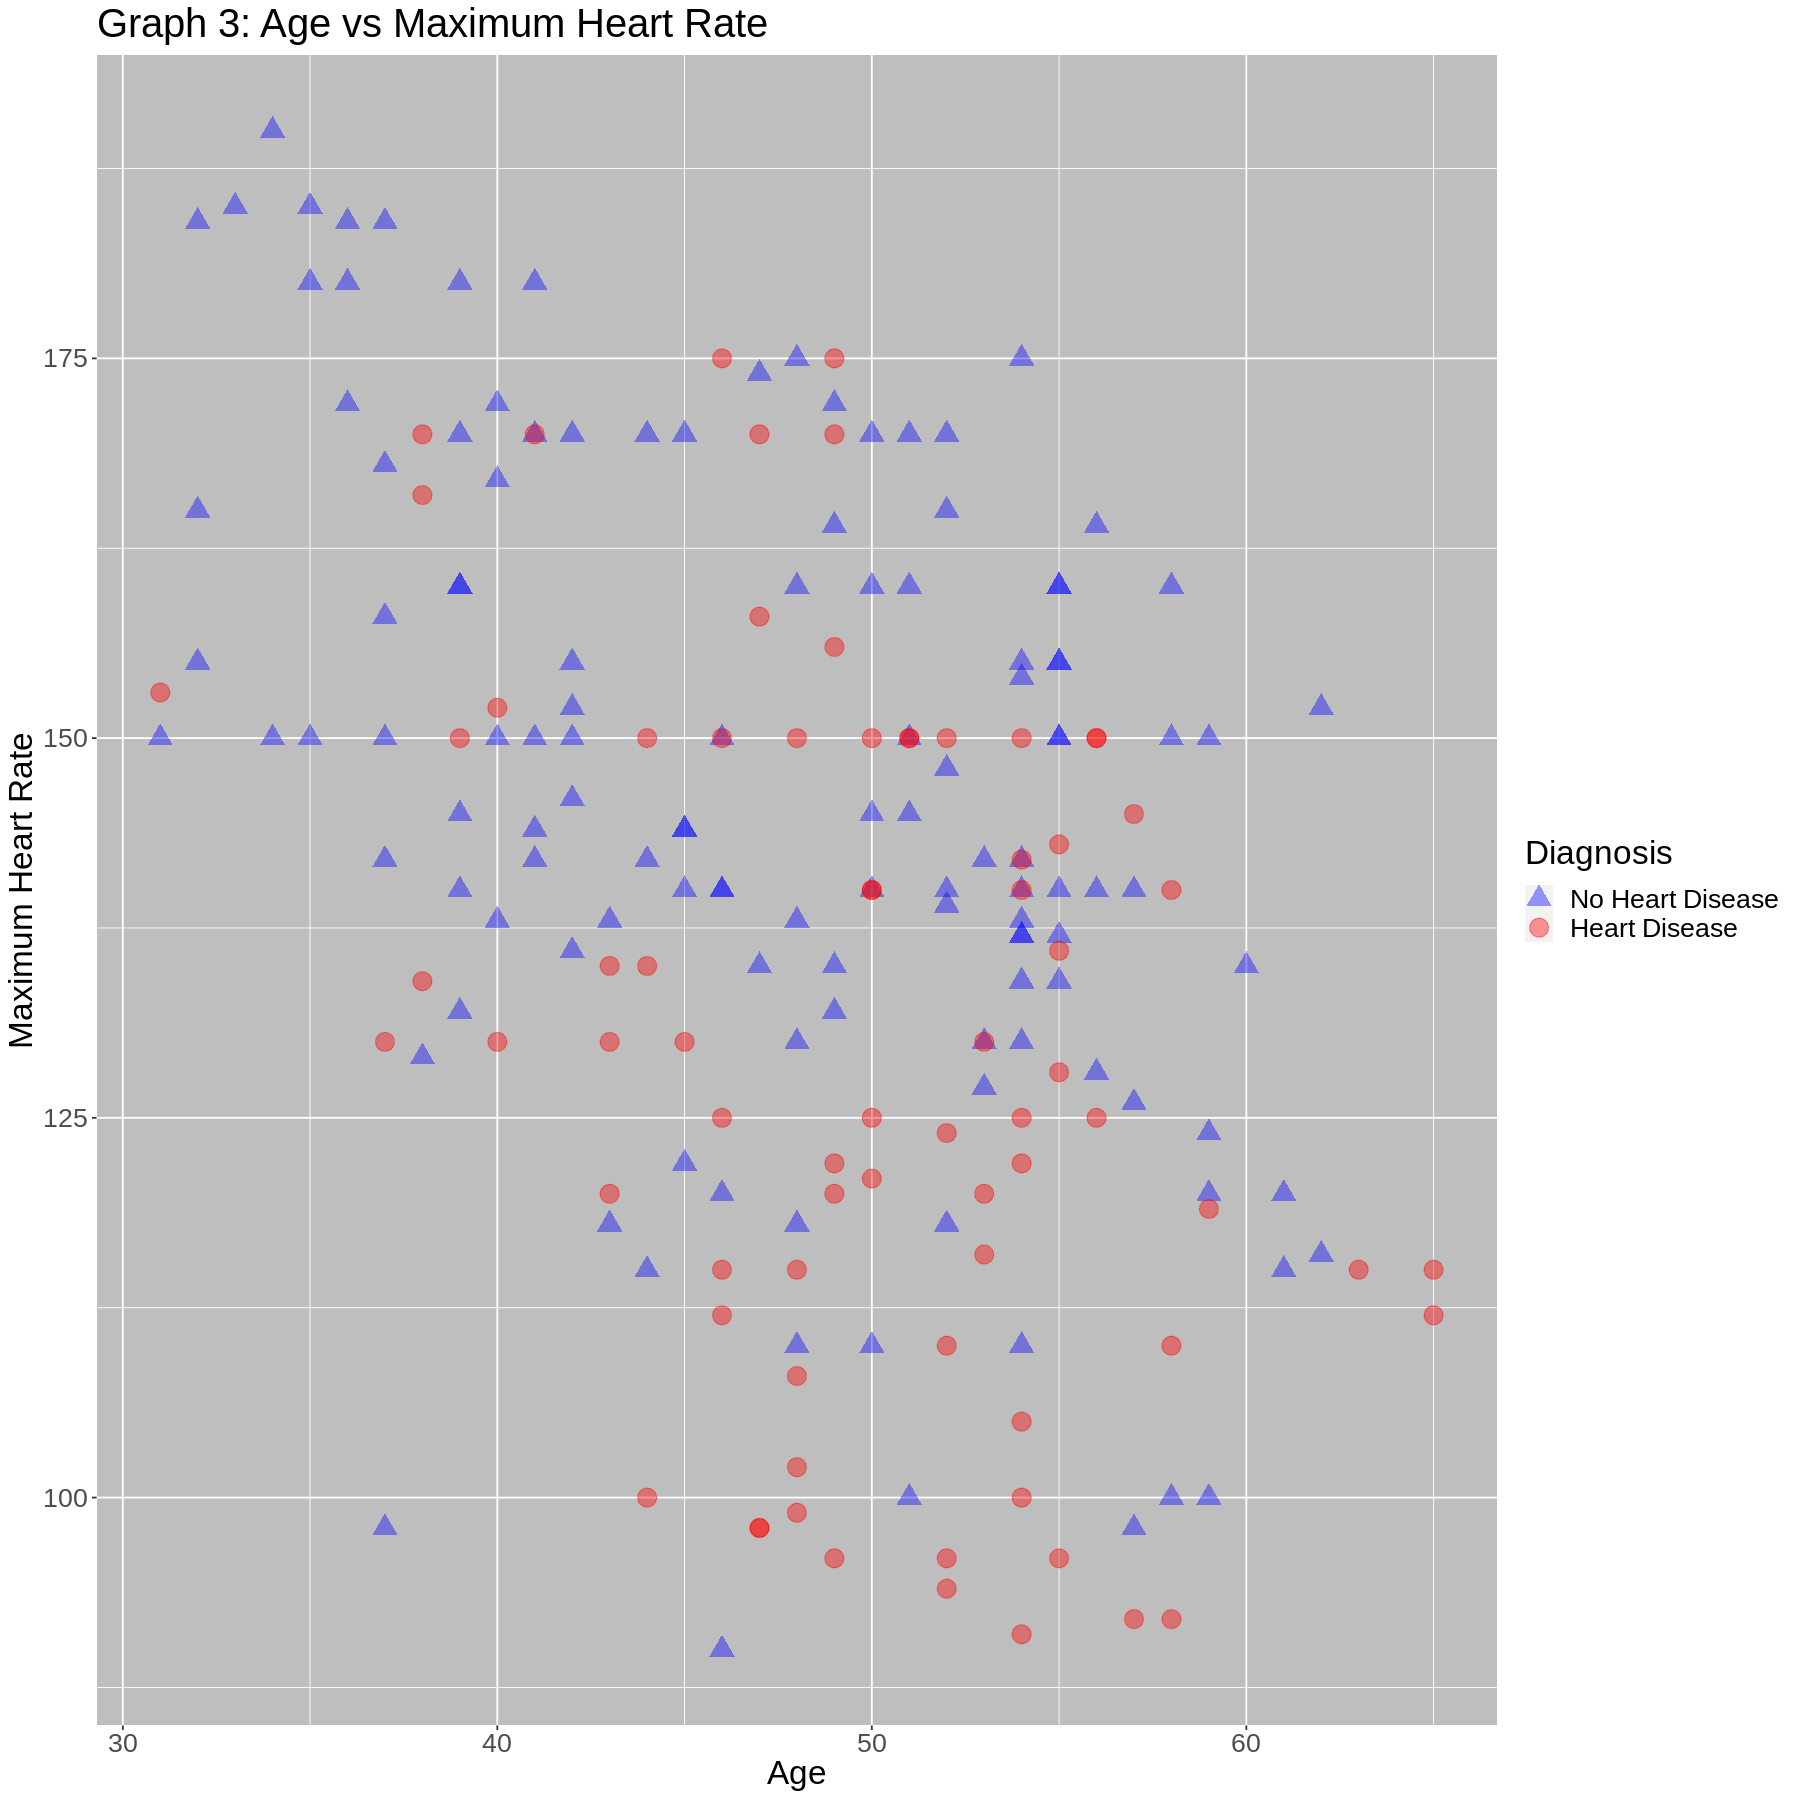

In [28]:
options(repr.plot.width = 15, repr.plot.height = 15)
max_heart_rate_vs_cholestoral_plot <- training_heart_data |>
    ggplot(aes(x = age, y = as.numeric(max_heart_rate), color = as.factor(diagnosis), shape = as.factor(diagnosis))) +
    geom_point(alpha = 0.4, size = 5) +
    labs(x = "Age", y = "Maximum Heart Rate", color = "Diagnosis", shape = "Diagnosis") +
    theme(text = element_text(size = 20), panel.background = element_rect(fill = "grey")) +
    scale_color_manual(labels = c("No Heart Disease", "Heart Disease"), values = c("blue", "red")) +
    scale_shape_manual(labels = c("No Heart Disease", "Heart Disease"), values = c("triangle", "circle")) +
    ggtitle("Graph 3: Age vs Maximum Heart Rate")
max_heart_rate_vs_cholestoral_plot

Patients with higher maximum heart rate are diagnosed less often. Older patients are diagnosed more often. Maximum heart rate and age appear to have a weak negative correlation.

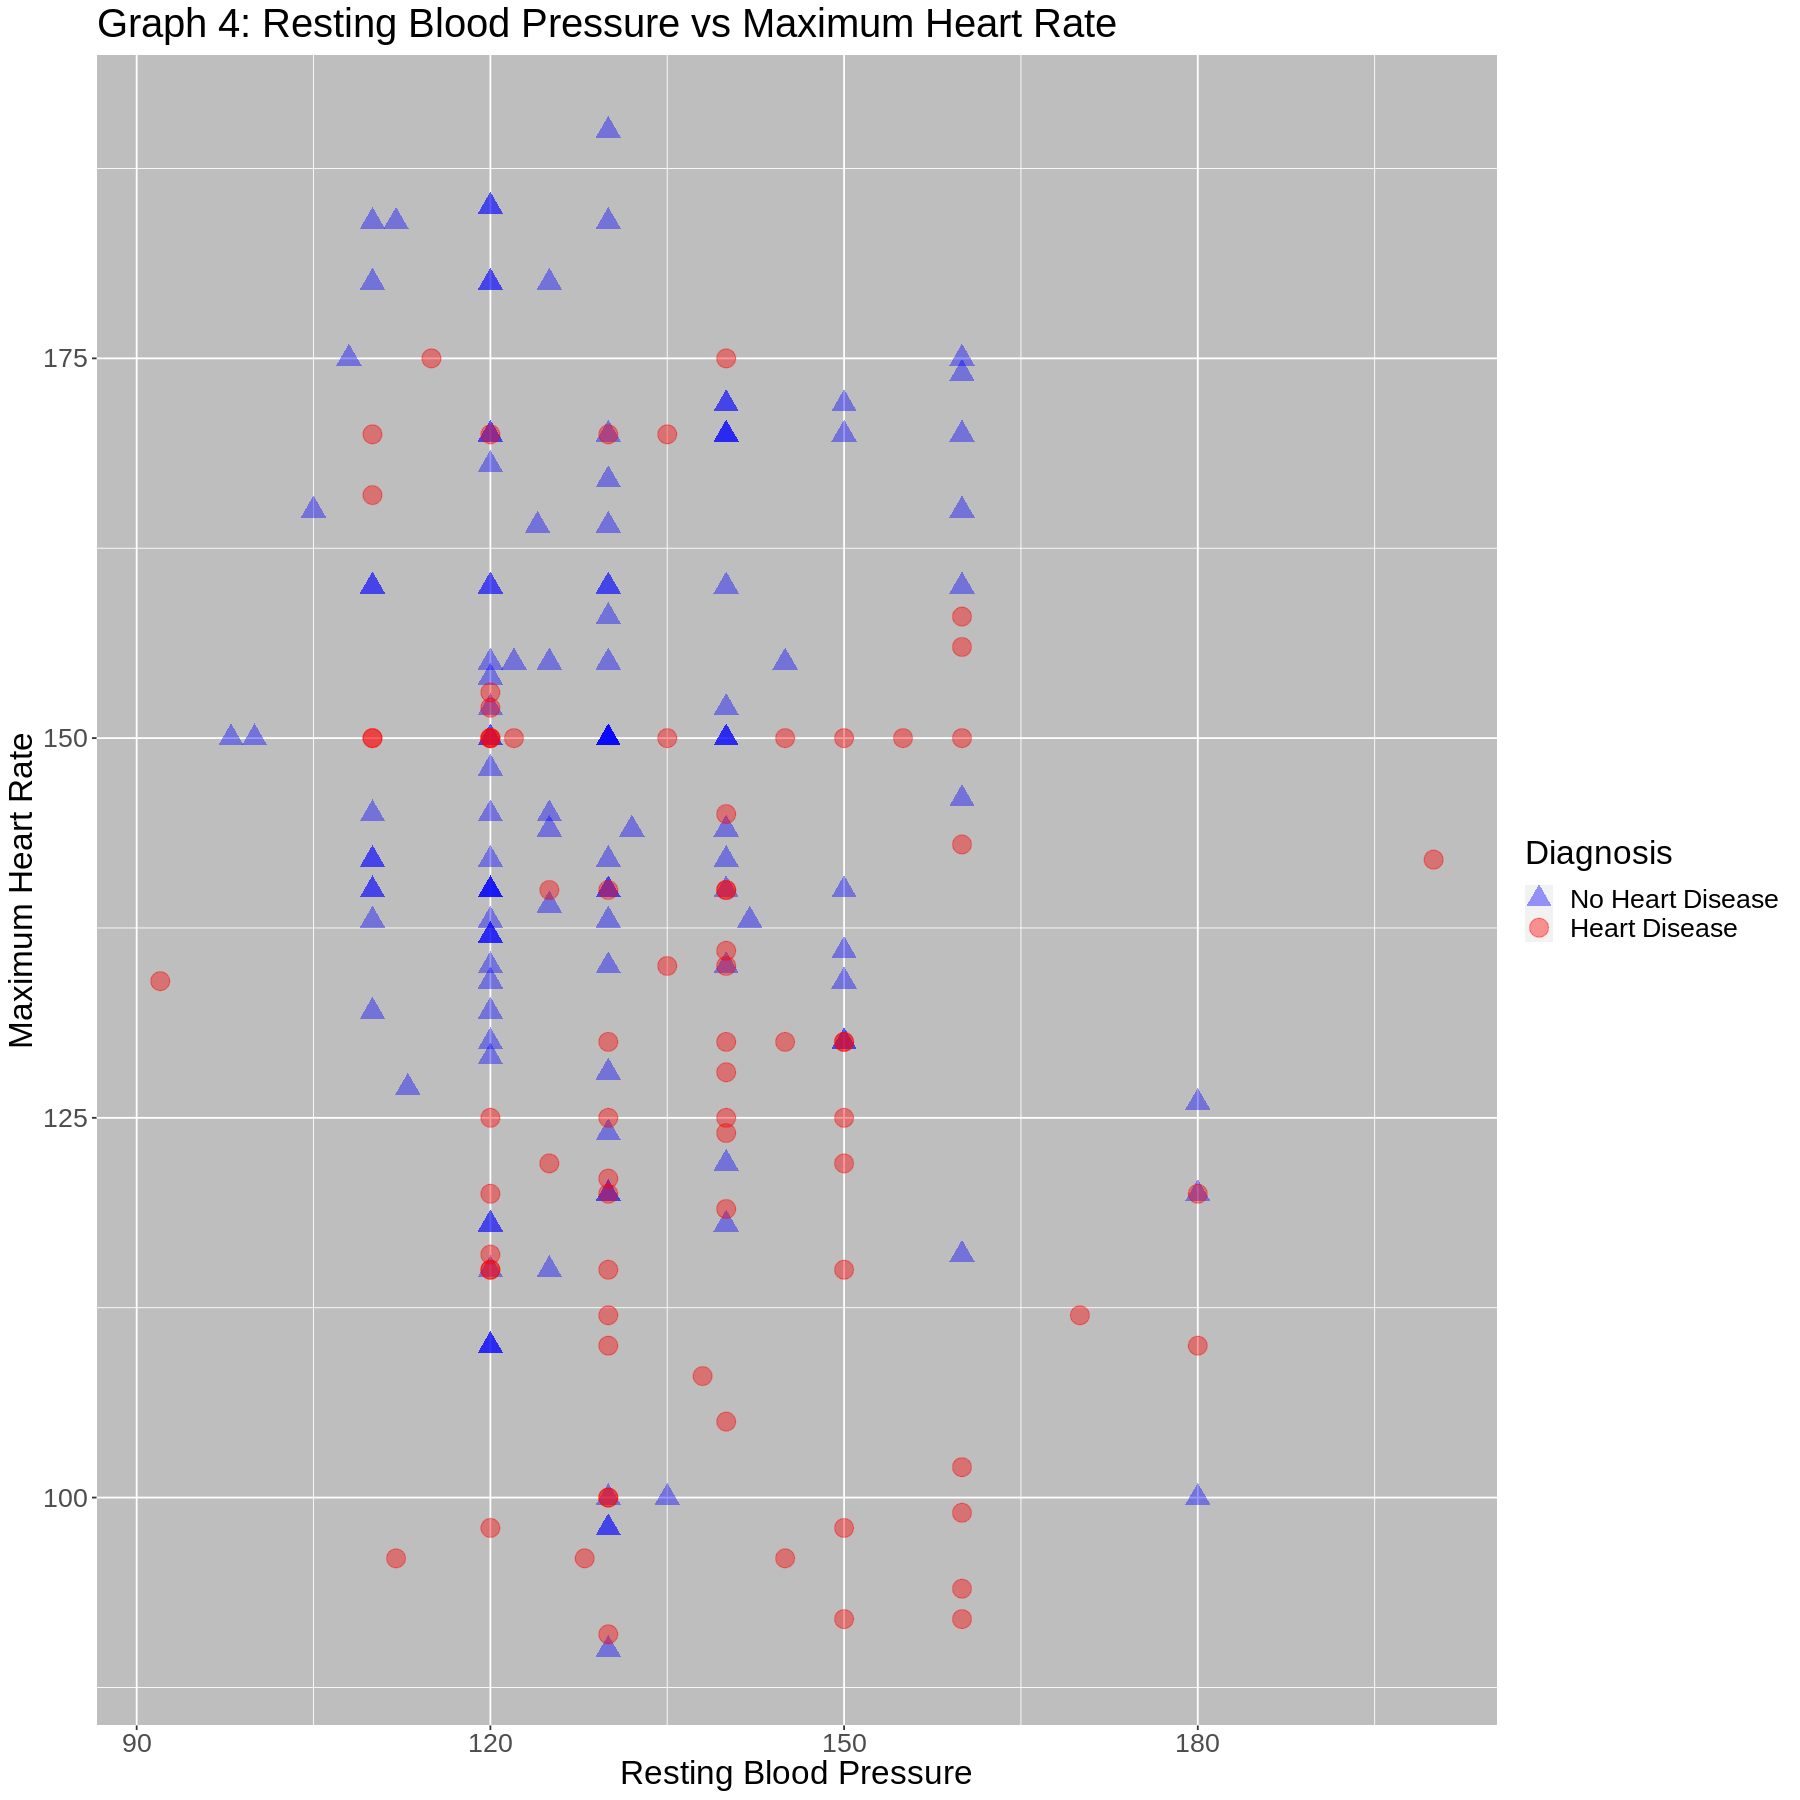

In [29]:
options(repr.plot.width = 15, repr.plot.height = 15)
resting_blood_pressure_vs_max_heart_rate_plot <- training_heart_data |>
    ggplot(aes(x = as.numeric(resting_blood_pressure), y = as.numeric(max_heart_rate), color = as.factor(diagnosis), shape = as.factor(diagnosis))) +
    geom_point(alpha = 0.4, size = 5) +
    labs(x = "Resting Blood Pressure", y = "Maximum Heart Rate", color = "Diagnosis", shape = "Diagnosis") +
    theme(text = element_text(size = 20), panel.background = element_rect(fill = "grey")) +
    scale_color_manual(labels = c("No Heart Disease", "Heart Disease"), values = c("blue", "red")) +
    scale_shape_manual(labels = c("No Heart Disease", "Heart Disease"), values = c("triangle", "circle")) +
    ggtitle("Graph 4: Resting Blood Pressure vs Maximum Heart Rate")
resting_blood_pressure_vs_max_heart_rate_plot

There does not appear to be a relationship between resting blood pressure and maximum heart rate as the points are fairly evenly distributed.

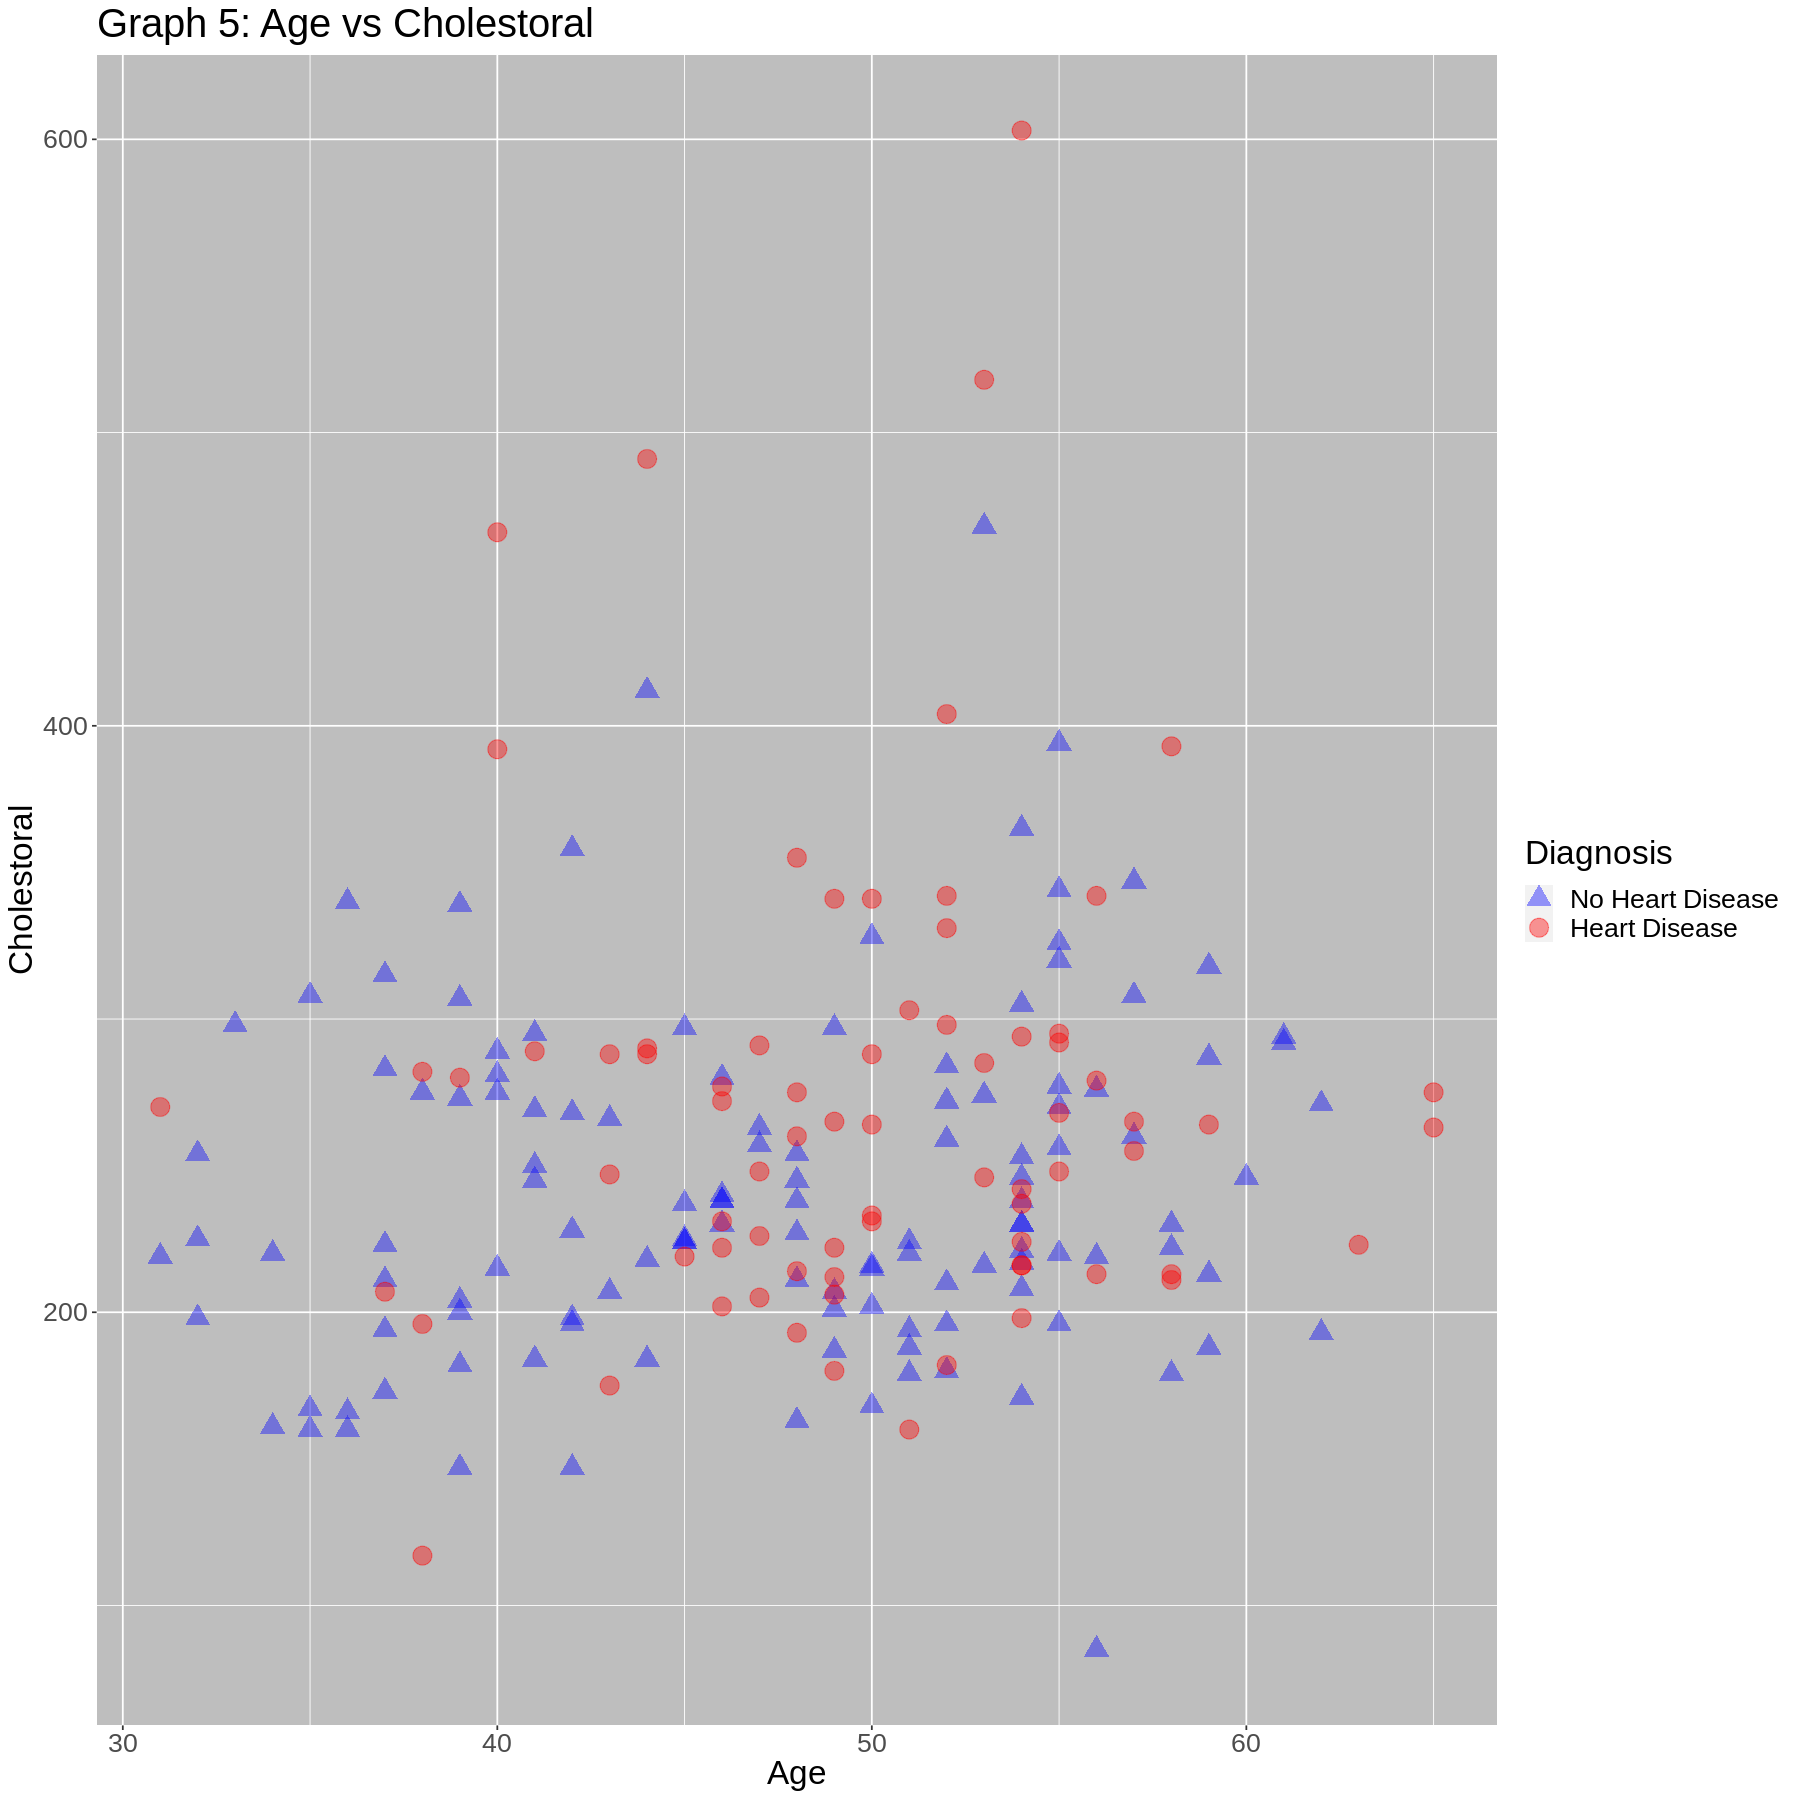

In [30]:
options(repr.plot.width = 15, repr.plot.height = 15)
age_vs_cholestoral_plot <- training_heart_data |>
    ggplot(aes(x = age, y = as.numeric(serum_cholestoral), color = as.factor(diagnosis), shape = as.factor(diagnosis))) +
    geom_point(alpha = 0.4, size = 5) +
    labs(x = "Age", y = "Cholestoral", color = "Diagnosis", shape = "Diagnosis") +
    theme(text = element_text(size = 20), panel.background = element_rect(fill = "grey")) +
    scale_color_manual(labels = c("No Heart Disease", "Heart Disease"), values = c("blue", "red")) +
    scale_shape_manual(labels = c("No Heart Disease", "Heart Disease"), values = c("triangle", "circle")) +
    ggtitle("Graph 5: Age vs Cholestoral")
age_vs_cholestoral_plot

Older patients are diagnosed more often. Patients with higher cholesterol are also diagnosed more often. There is no relationship between cholesterol and age.

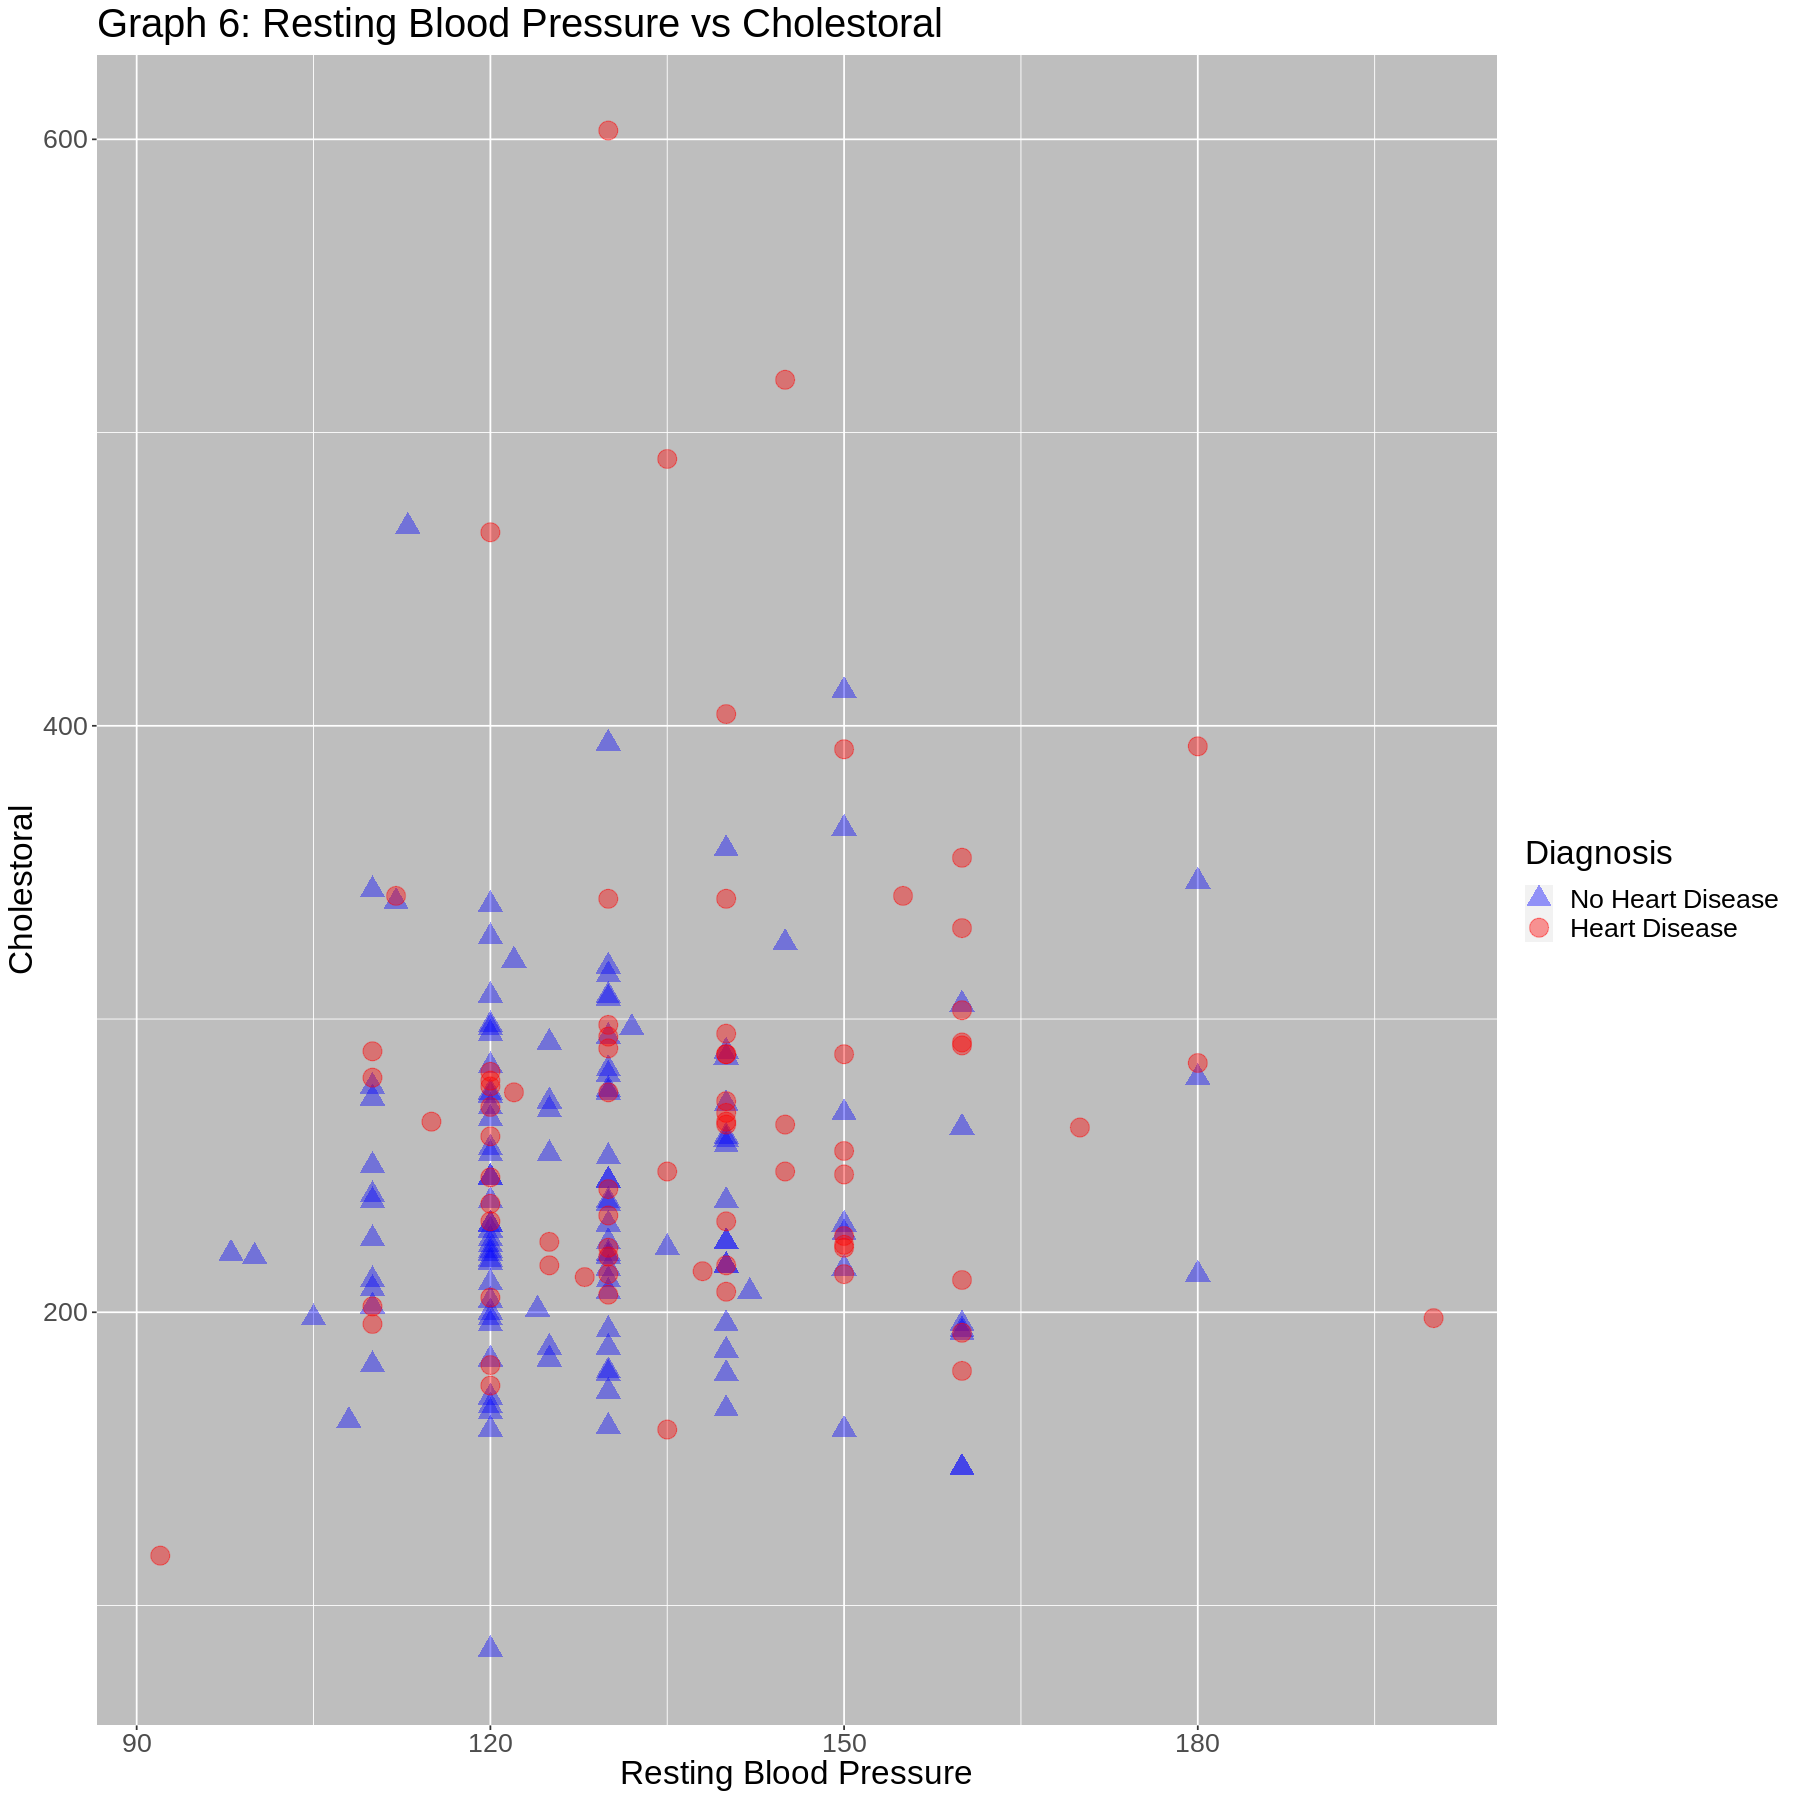

In [31]:
options(repr.plot.width = 15, repr.plot.height = 15)
cholestoral_vs_resting_blood_pressure_plot <- training_heart_data |>
    ggplot(aes(x = as.numeric(resting_blood_pressure), y = as.numeric(serum_cholestoral), color = as.factor(diagnosis), shape = as.factor(diagnosis))) +
    geom_point(alpha = 0.4, size = 5) +
    labs(x = "Resting Blood Pressure", y = "Cholestoral", color = "Diagnosis", shape = "Diagnosis") +
    theme(text = element_text(size = 20), panel.background = element_rect(fill = "grey")) +
    scale_color_manual(labels = c("No Heart Disease", "Heart Disease"), values = c("blue", "red")) +
    scale_shape_manual(labels = c("No Heart Disease", "Heart Disease"), values = c("triangle", "circle")) +
    ggtitle("Graph 6: Resting Blood Pressure vs Cholestoral")
cholestoral_vs_resting_blood_pressure_plot


There is no correlation between cholesterol and resting blood pressure in relation to diagnosis.

**METHODS**

Our classifier will be based on the following predictor variables: age and maximum heart rate. Graphs 1, 3, and 5 show older patients are more often diagnosed with heart disease while graphs 2, 3, and 4 show patients with lower maximum heart rate are more often diagnosed. These are both good predictors of heart disease because older people tend to have lower maximum heart rate which increases risk of heart disease (Harvard Health, 2020). 

We will create our model by scaling the predictor variables, creating a recipe, and training the model on the training data. After tuning the model for the most accurate K value 5-fold using cross validation we will train the model on the training set and then use it to predict the classes of the testing set to test its accuracy. We will visualize our model's accuracy with a confusion matrix table and a bar graph showing which diagnoses were correctly or incorrectly predicted. 

**Model**

age,max_heart_rate,diagnosis
<dbl>,<dbl>,<fct>
28,185,0
29,160,0
30,170,0
31,150,0
32,165,0
32,184,0


Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 5
  weight_func = rectangular

Computational engine: kknn 


.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.6519512,5,0.01635625,Preprocessor1_Model1
roc_auc,binary,0.6793538,5,0.01984229,Preprocessor1_Model1


K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6174390,5,0.028994912,Preprocessor1_Model01
11,accuracy,binary,0.6618293,5,0.016088320,Preprocessor1_Model02
21,accuracy,binary,0.6814634,5,0.021892367,Preprocessor1_Model03
31,accuracy,binary,0.6813415,5,0.019221926,Preprocessor1_Model04
41,accuracy,binary,0.6763415,5,0.024450687,Preprocessor1_Model05
51,accuracy,binary,0.6763415,5,0.026885612,Preprocessor1_Model06
61,accuracy,binary,0.6715854,5,0.021655872,Preprocessor1_Model07
71,accuracy,binary,0.6418293,5,0.009467138,Preprocessor1_Model08
81,accuracy,binary,0.6268293,5,0.001829268,Preprocessor1_Model09


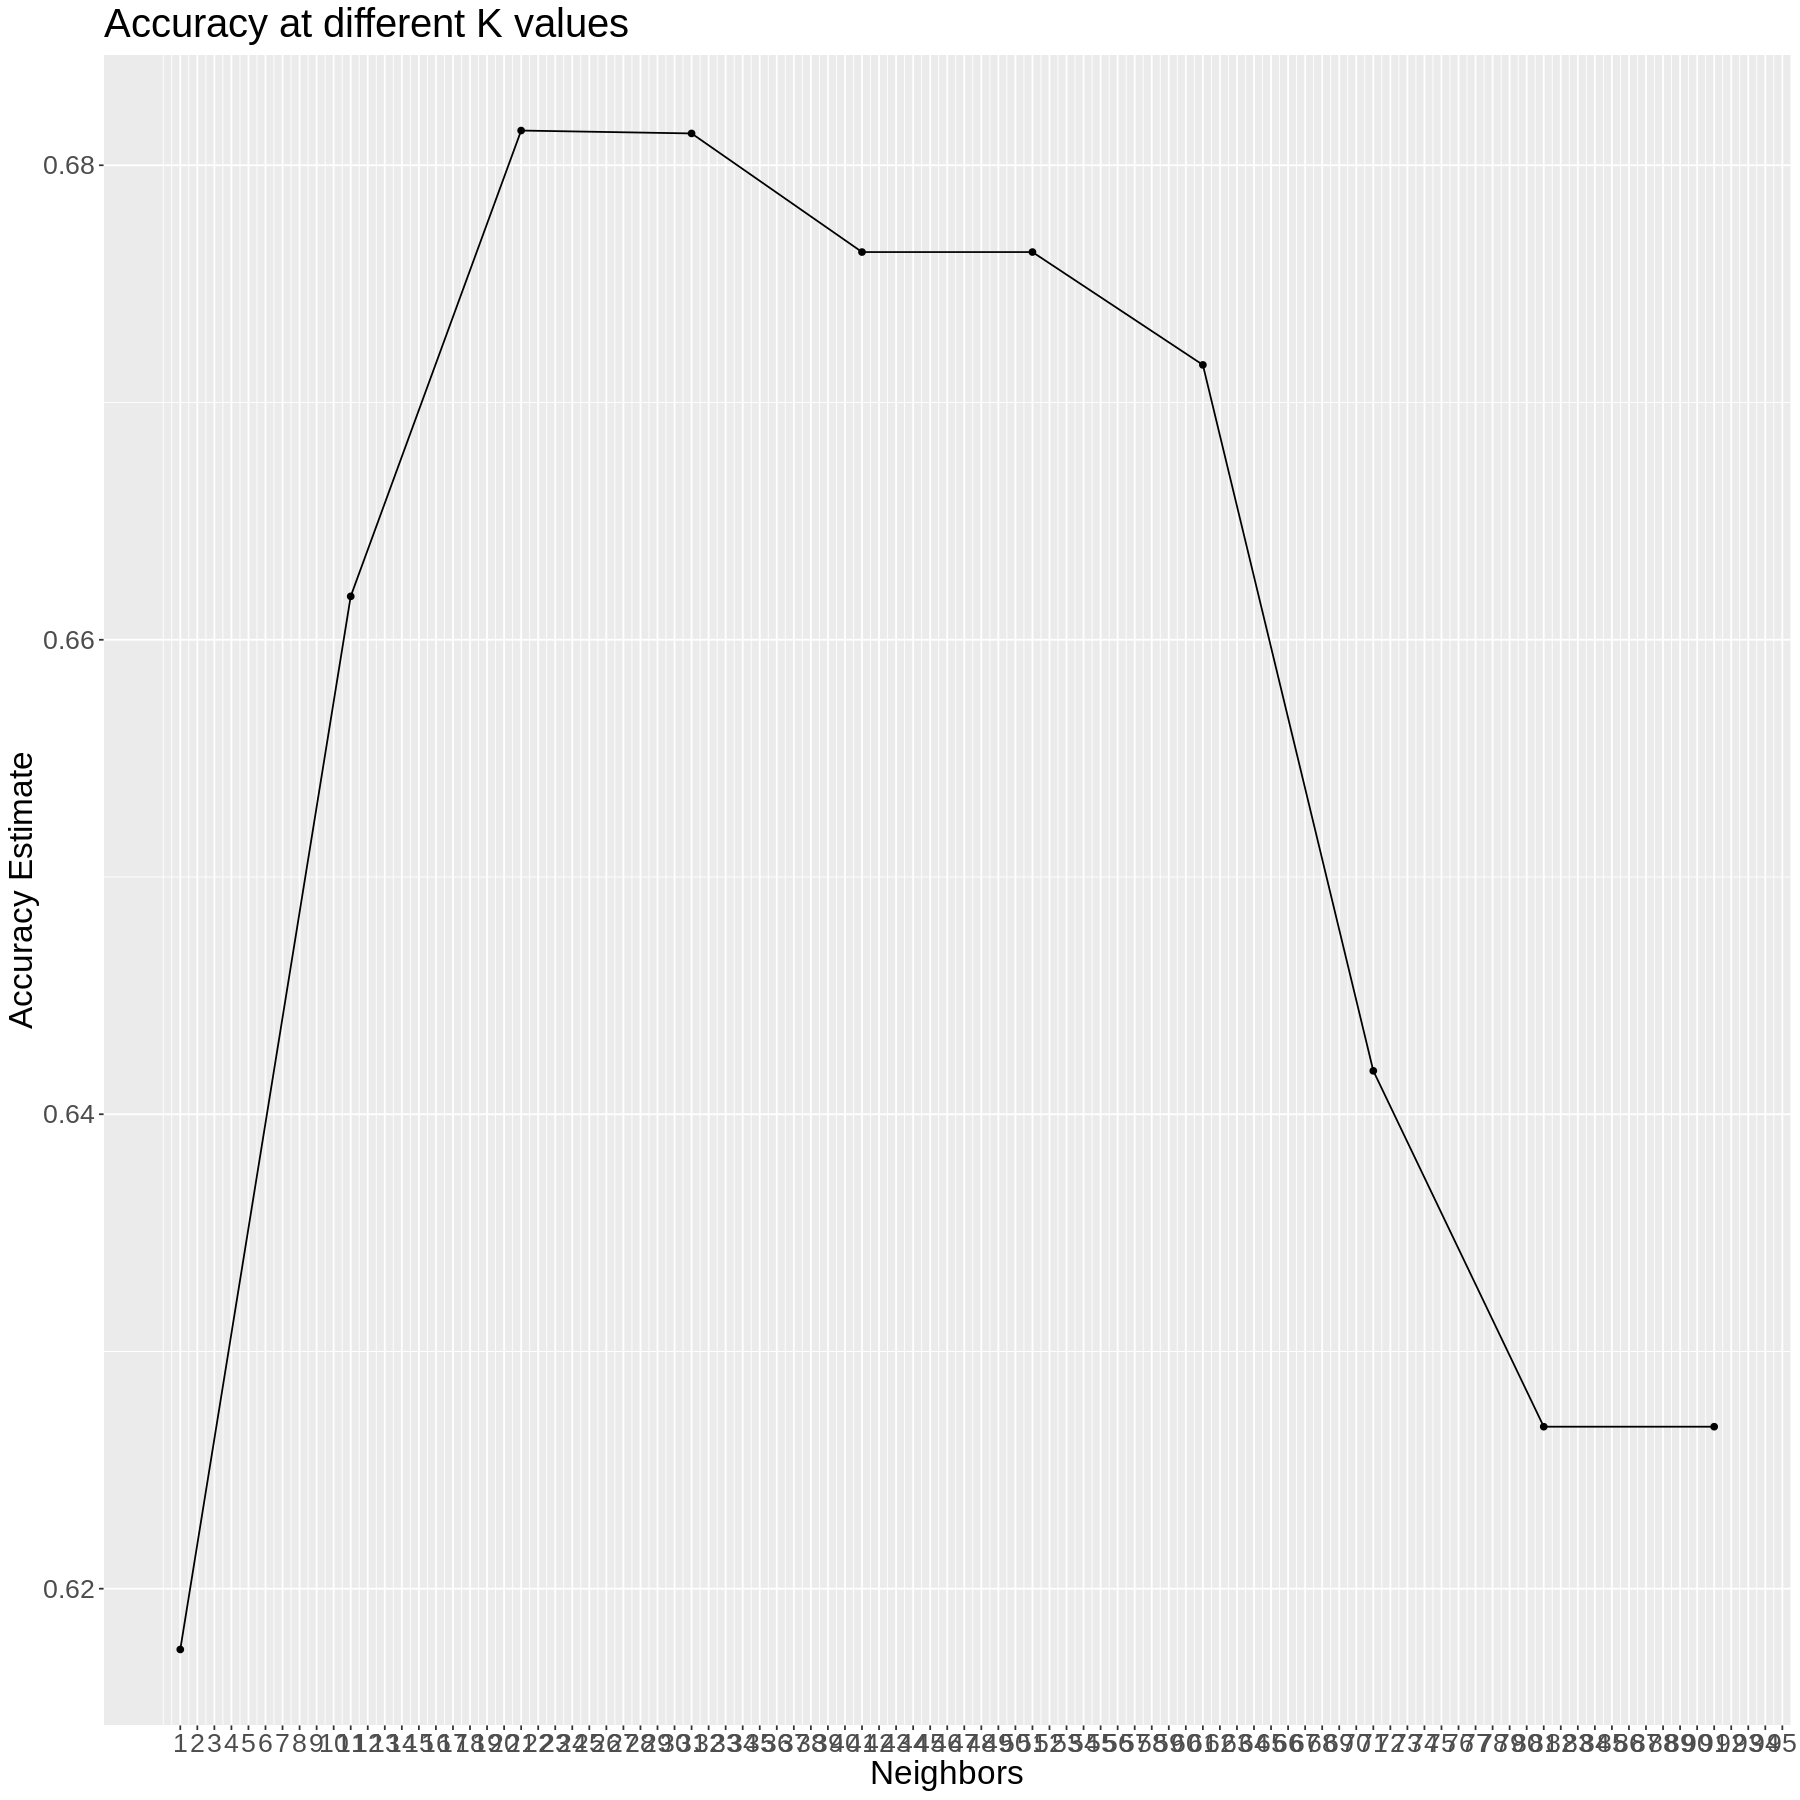

In [39]:
set.seed(1234)
#selecting the columns we are using to build our model and making predictors numeric
heart_predictors_data <- tidy_heart_data |>
    select(age, max_heart_rate, diagnosis) |>
    mutate(age = as.numeric(age), max_heart_rate = as.numeric(max_heart_rate))

head(heart_predictors_data)

#splitting data into training and testing
heart_split <- initial_split(heart_predictors_data, prop = 0.75, strata = diagnosis)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

#splitting training data for tuning for the best K value
# train_split <- initial_split(heart_train, prop = 0.75, strata = diagnosis)
# subtrain <- training(train_split)
# validation <- testing(train_split)
#don't need????

#creating the folds for cross validation
vfold <- vfold_cv(heart_train, v = 5, strata = diagnosis)

#making the recipe to predict diagnosis from age and max heart rate
heart_recipe <- recipe(diagnosis ~ age + max_heart_rate, data = heart_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

heart_recipe

#making the knn specifications for the cross validation
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_spec

#making the workflow
knn_fit <- workflow() |>
    add_recipe(heart_recipe) |> 
    add_model(knn_spec) |> 
    fit_resamples(resamples = vfold) |>
    collect_metrics() 

knn_fit

#tuning the model to choose the best K
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_tune

#specifying range of k to choose from
kvals <- tibble(neighbors = seq(from = 1, to = 100, by = 10))

#fitting the model to each value of the range of k
knn_results <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_tune) |> 
    tune_grid(resamples = vfold, grid = kvals) |> 
    collect_metrics()

model_accuracies <- knn_results |>
     filter(.metric == "accuracy")

model_accuracies

accuracy_vs_k <- ggplot(model_accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    ggtitle("Accuracy at different K values") +
    scale_x_continuous(breaks = 1:100) +
    theme(text = element_text(size = 20))

accuracy_vs_k

After a general browsing, we can infer that the most suitable value of k is in the range of [25,45]. To find out this specific value, we can re-scale the data to figure it out. 

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
25,accuracy,binary,0.6863415,5,0.01778001,Preprocessor1_Model01
26,accuracy,binary,0.6863415,5,0.01778001,Preprocessor1_Model02
27,accuracy,binary,0.6963415,5,0.01895841,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
43,accuracy,binary,0.6813415,5,0.0248894,Preprocessor1_Model19
44,accuracy,binary,0.6813415,5,0.0248894,Preprocessor1_Model20
45,accuracy,binary,0.6813415,5,0.0248894,Preprocessor1_Model21


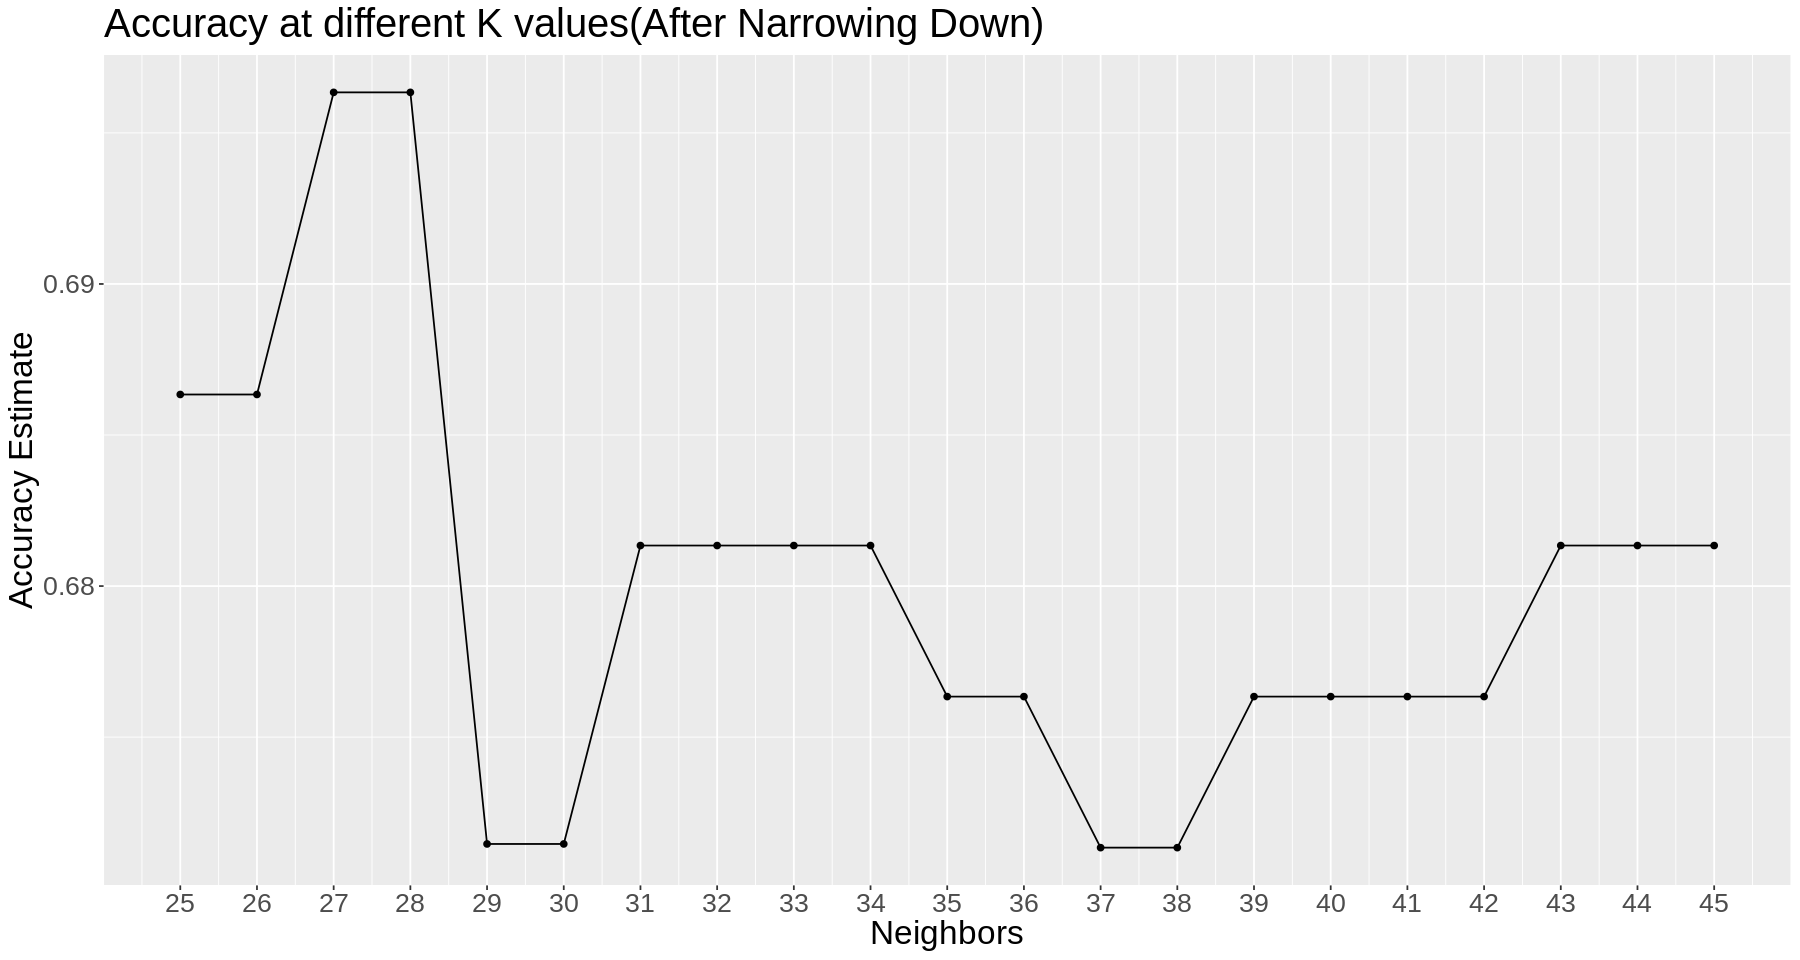

In [82]:
#specifying range of k to choose from
kvals_2 <- tibble(neighbors = seq(from = 25, to = 45, by = 1))

#fitting the model to each value of the range of k
knn_results_2 <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_tune) |> 
    tune_grid(resamples = vfold, grid = kvals_2) |> 
    collect_metrics()

model_accuracies_2 <- knn_results_2 |>
     filter(.metric == "accuracy")

model_accuracies_2

accuracy_vs_k_2 <- ggplot(model_accuracies_2, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    ggtitle("Accuracy at different K values(After Narrowing Down)") +
    scale_x_continuous(breaks = 25:45) +
    theme(text = element_text(size = 20))

accuracy_vs_k_2

Based on this plot of accuracies we decide to use 27 neighbours for our model to get the most accurate predictions because this gives us an accuracy of 69.6%.

In [40]:
#Now we train our model using 8 neighbors
knn_spec_k8 <- nearest_neighbor(weight_func = "rectangular", neighbors = 27) |>
    set_engine("kknn") |>
    set_mode("classification")

#we use the same recipe as above
knn_fit <- workflow() |> 
    add_recipe(heart_recipe) |> 
    add_model(knn_spec_k8) |> 
    fit(data = heart_train)

#we test this models predictions using the testing data
heart_test_preds <- predict(knn_fit, heart_test) |>
    bind_cols(heart_test)

heart_test_preds

heart_preds_accuracy <- heart_test_preds |>
    metrics(truth = diagnosis, estimate = .pred_class) |>
    filter(.metric == "accuracy")

heart_preds_accuracy

#we also make a confusion matrix to visualize the models accuracy
confusion_matrix <- heart_test_preds |>
    conf_mat(truth = diagnosis, estimate = .pred_class)

confusion_matrix


.pred_class,age,max_heart_rate,diagnosis
<fct>,<dbl>,<dbl>,<fct>
0,28,185,0
0,32,165,0
0,32,155,0
0,35,185,0
0,35,150,0
0,35,168,0
0,36,178,0
1,37,98,0
0,39,160,0


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6086957


          Truth
Prediction  0  1
         0 36 20
         1  7  6

This confusion matrix tells us that 42 predictions were correct and 27 were predicted incorrectly out of a total of 69 predictions. This model has an accuracy of 60.87%. There were 20 patients with heart disease that were predicted to not have it which is a large amount of misses (20 missed out of the 26 patients with heart disease in the testing data). On the other hand there were only 7 of the 43 patients without heart disease that were predicted to have it. This means our data is conservtive when it comes to predicting the presence of heart disease and tends toward predicting no heart disease.  

**OUTCOMES AND SIGNIFICANCE** 

We expect our classification model to accurately predict whether individuals have heart disease based on age and maximum heart rate. This is significant because it will provide faster and more accurate diagnoses for people with risk factors for heart disease. By predicting the presence of heart disease earlier, this could revolutionize healthcare through early administration of treatment regimens. 

Further questions include whether other variables aside from those in the Hungarian data set contribute to heart disease and could improve the accuracy of our model. We could also question whether incorporating data from other countries into our model would increase it's accuracy.


**REFERENCES**

World Health Organization. (n.d.). Cardiovascular diseases. World Health Organization. Retrieved March 10, 2023, from https://www.who.int/health-topics/cardiovascular-diseases/ 

Centers for Disease Control and Prevention. (2022, July 12). About heart disease. Centers for Disease Control and Prevention. Retrieved March 10, 2023, from https://www.cdc.gov/heartdisease/about.htm 

WebMD. (n.d.). High cholesterol and high blood pressure. WebMD. Retrieved March 10, 2023, from https://www.webmd.com/cholesterol-management/high-cholesterol-and-high-blood-pressure 

UCI Machine Learning Repository: Heart disease data set. (n.d.). Retrieved March 10, 2023, from https://archive.ics.uci.edu/ml/datasets/Heart+Disease 

What your heart rate is telling you. Harvard Health. (2020, August 30). Retrieved March 11, 2023, from https://www.health.harvard.edu/heart-health/what-your-heart-rate-is-telling-you